In [1]:
import matplotlib
import os
%matplotlib inline
from Wavefront import zernike

import numpy as np
import matplotlib.pyplot as plt
import numpy.lib.index_tricks as itricks
from scipy.special import jv
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

main_directory = '/nfs/slac/g/ki/ki19/lsst/snyder18'
data_directory = '/nfs/slac/g/ki/ki19/lsst/snyder18/Data'
results_directory = '/nfs/slac/g/ki/ki19/lsst/snyder18/Results'

/nfs/slac/g/ki/ki06/roodman/Software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def noll_to_zern(j):
    """
    Convert linear Noll index to tuple of Zernike indices.
    j is the linear Noll coordinate, n is the radial Zernike index and m is the azimuthal Zernike index.
    @param [in] j Zernike mode Noll index
    @return (n, m) tuple of Zernike indices
    @see <https://oeis.org/A176988>.
    """
    if (j == 0):
        raise ValueError("Noll indices start at 1, 0 is invalid.")

    n = 0
    j1 = j-1
    while (j1 > n):
        n += 1
        j1 -= n

    m = (-1)**j * ((n % 2) + 2 * int((j1+((n+1)%2)) / 2.0 ))
    return (n, m)

Generalized Kolmogorov atmospheric model

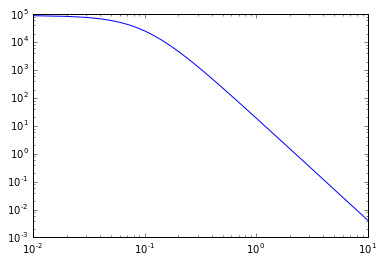

In [3]:
## Generalized Kolmogorov model
L0 = 10.
l = 0.01

k = np.linspace(0, 10, 1000)
D = 8.0
k_i = 1/l
k_o = 1/L0
r0 = 0.14

powerlaw_full = 0.023*(D/r0)**(5./3.)*np.exp(-k**2./(k_i**2.))*(k**2.+k_o**2.)**(-11./6.)


plt.loglog(k, powerlaw_full)
plt.show()

Make Zernike polynomial arrays

In [4]:
# build the x,y grid
nZ = 37
nbin=256

pupildiameter = 8.0
radiusOuter = 4.0
lo = -pupildiameter/2.
hi = pupildiameter/2.
yaxis, xaxis = itricks.mgrid[lo:hi:1j*nbin, lo:hi:1j*nbin]

# build the rho, theta areas on the pupil
rho = np.sqrt(xaxis*xaxis+yaxis*yaxis)/radiusOuter
theta = np.arctan2(yaxis, xaxis)

zpoly = zernike.Zernike(rho, theta, nZ)

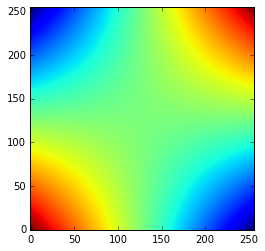

In [5]:
noll = 5

plt.imshow(zpoly.ZernikeTerm[noll-1], origin='lower')

Playing with Zernike polynomial Fourier transforms

In [6]:
def fpolar(alpha, n, m):
    if m > 0:
        pre = (-1)**((n-abs(m))/2.)*(1j)**abs(m)
        fix = np.sqrt(2.)*np.cos(abs(m)*alpha)
    elif m < 0:
        pre = (-1)**((n-abs(m))/2.)*(1j)**abs(m)
        fix = np.sqrt(2.)*np.sin(abs(m)*alpha)
    elif m == 0:
        pre = (-1)**(n/2.)
        fix = np.ones(alpha.shape)
    return pre*fix

Fourier Transform of Zernike polynomial

2 -2


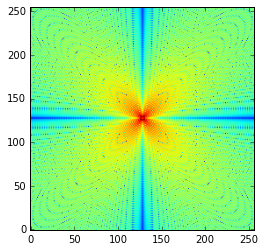

In [7]:
flo = -nbin/(pupildiameter)
fhi = nbin/(pupildiameter)

fyaxis, fxaxis = itricks.mgrid[flo:fhi:1j*nbin, flo:fhi:1j*nbin]
f = np.sqrt(fxaxis*fxaxis+fyaxis*fyaxis)
alpha = np.arctan2(fyaxis, fxaxis)

n, m = noll_to_zern(noll)
print n, m

Q_analytic = (-1)**n*np.sqrt(n+1)*jv(n+1, 2*np.pi*f)/(np.pi*f)*fpolar(alpha, n, m)
plt.imshow(np.log(np.abs(Q_analytic)**2), origin='lower')

In [268]:
flo = -500.
fhi = 500.
#vel = 10.0

kyaxis, kxaxis = itricks.mgrid[klo:khi:1j*256, klo:khi:1j*256]
k = np.sqrt(kxaxis*kxaxis+kyaxis*kyaxis)

In [2]:
phasefile = 'ugp_When_2015.11.6_4.43.46_poldm_phase'
zernike_datapath = os.path.join(results_directory, "{0}_GPI".format(phasefile), 
                                "{0}_GPI_periodograms.csv".format(phasefile))
PSD = np.loadtxt(zernike_datapath, dtype=np.float64, delimiter=',')
frequency = PSD[0,:]
periodograms = PSD[1:,:]

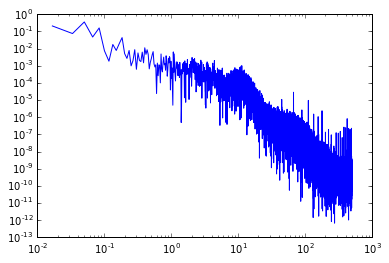

In [7]:
plt.loglog(frequency[1:], periodograms[30,1:])

Practice fitting using Z=5

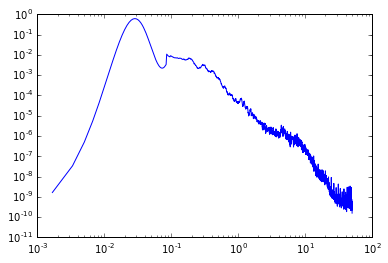

In [208]:
Z_noll = 5

smoothed = 10**savgol_filter(np.log10(periodograms[Z_noll-1,:]), 101, 5)
plt.loglog(frequency[:], smoothed)

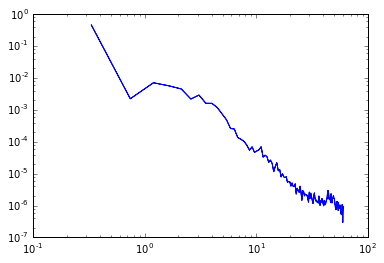

In [275]:
slice = np.interp(k[k.shape[0]/2, :], frequency, smoothed)
plt.loglog(k[k.shape[0]/2,:], slice)

In [276]:
powerlaw = np.zeros(k.shape)

for i in range(k.shape[0]):
    for j in range(k.shape[1]):
        powerlaw[i,j] = np.interp(k[i,j], frequency, smoothed)

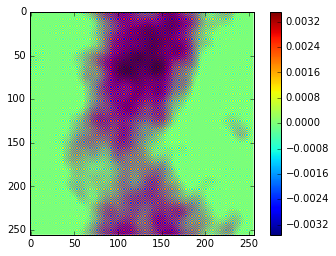

In [277]:
noise = np.random.randn(k.shape[0], k.shape[1])
noiseFT = np.fft.fft2(noise) * powerlaw

focalplane = np.fft.ifft2(noiseFT).real


fig, ax = plt.subplots()
cax = ax.imshow(focalplane, interpolation='none')

cbar = fig.colorbar(cax)

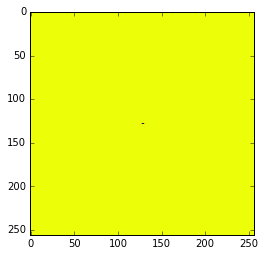

In [278]:
x = np.fft.fft2(focalplane)

plt.imshow(x.real)

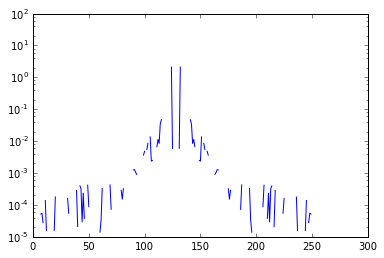

In [280]:
plt.semilogy(x[x.shape[0]/2, :].real)

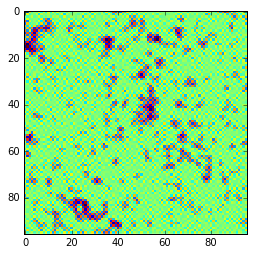

In [118]:
plt.imshow(focalplane[0:96, 0:96], interpolation='none')

In [107]:
150*256/400.

96.0

In [117]:
1/frequency[1]

59.907000000000004